## Head Pose Model (6DRepNet) demo

영상을 불러와, Head Pose 모델로 머리의 상하좌우 각도와 회전 각도를 추론하는 코드

https://github.com/thohemp/6DRepNet 저장소를 Clone하여 실험

환경 설정은 되어있다 가정

*객체 추적 결과를 이용한 실험은 실험 진행 후 별개의 파일로 업로드 예정 (해당 파일의 테스트 영상에서는 사람이 한 명만 등장함)*

In [22]:
!git clone https://github.com/thohemp/6DRepNet.git
%cd 6DRepNet

Cloning into '6DRepNet'...
remote: Enumerating objects: 329, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 329 (delta 116), reused 108 (delta 93), pack-reused 182
Receiving objects: 100% (329/329), 98.80 KiB | 1.47 MiB/s, done.
Resolving deltas: 100% (186/186), done.
/content/6DRepNet/6DRepNet


In [23]:
# SixDRepNet 불러오기
from sixdrepnet import SixDRepNet
import cv2

# 모델 생성 - 가중치는 자동으로 다운로드
model = SixDRepNet()

In [24]:
model

In [25]:
import torch
torch.cuda.is_available()

True

In [26]:
# yaw(z축, 좌우 회전 각도)를 나타내는 선을 굵은 노란색으로 바꾸기 위해서 utils.py의 draw_axis 함수 사용
# yaw를 굵게 표시한 이유 - 세 축 중 가장 의미있는 정보가 될 것 같음

import cv2
import numpy as np
from math import cos, sin

def draw_axis(img, yaw, pitch, roll, tdx=None, tdy=None, size=100):
    pitch = pitch * np.pi / 180
    yaw = -(yaw * np.pi / 180)
    roll = roll * np.pi / 180

    if tdx is not None and tdy is not None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis (Pitch) pointing to right, drawn in red and made thinner
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy
    cv2.line(img, (int(tdx), int(tdy)), (int(x1), int(y1)), (0, 0, 255), 1)  # Thinner line for Pitch

    # Y-Axis (Roll) | drawn in green and made thinner
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy
    cv2.line(img, (int(tdx), int(tdy)), (int(x2), int(y2)), (0, 255, 0), 1)  # Thinner line for Roll

    # Z-Axis (Yaw) (out of the screen) drawn in yellow and made thicker
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy
    cv2.line(img, (int(tdx), int(tdy)), (int(x3), int(y3)), (0, 255, 255), 4)  # Thicker yellow line for Yaw

    return img

In [27]:
import cv2
import numpy as np

frame_list = []
pitch_values = []
yaw_values = []
roll_values = []


# 동영상 로드
cap = cv2.VideoCapture('/content/notebook_girl.mp4')

# 동영상의 프레임 속도와 크기
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# 출력 동영상 설정
out = cv2.VideoWriter('output_video.mp4', cv2.VideoWriter_fourcc(*'MP4V'), fps, (frame_width, frame_height), isColor=False)


while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # 모델 처리
    pitch, yaw, roll = model.predict(frame)

    # pitch, yaw, roll 값 리스트에 저장
    pitch_values.append(pitch)
    yaw_values.append(yaw)
    roll_values.append(roll)

    # revise 함수 적용
    frame = draw_axis(frame, yaw, pitch, roll)

    # 수정된 프레임을 동영상에 추가
    out.write(frame)
    frame_list.append(frame)

cap.release()
out.release()

<ipython-input-26-2b0bb18faf1c>:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x1 = size * (cos(yaw) * cos(roll)) + tdx
<ipython-input-26-2b0bb18faf1c>:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy
<ipython-input-26-2b0bb18faf1c>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x2 = size * (-cos(yaw) * sin(roll)) + tdx
<ipython-input-26-2b0bb18faf1c>:28: DeprecationWarning: Conve

yaw value: [26.675838]
pitch value: [-20.169924]


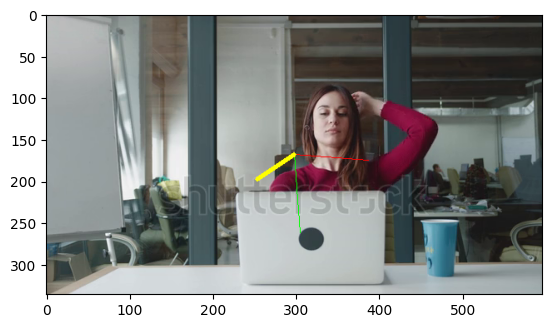

In [28]:
# 지정한 프레임에서의 추론 결과 시각화
import matplotlib.pyplot as plt

img = cv2.cvtColor(frame_list[10], cv2.COLOR_BGR2RGB)
print("yaw value:", yaw_values[10])
print("pitch value:", pitch_values[10])
plt.imshow(img)

yaw value: [9.401864]
pitch value: [-26.463911]


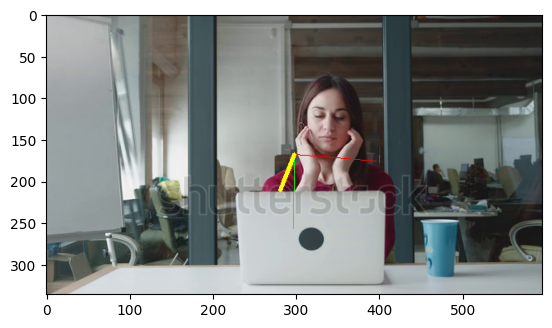

In [29]:
# 지정한 프레임에서의 추론 결과 시각화
import matplotlib.pyplot as plt

img = cv2.cvtColor(frame_list[50], cv2.COLOR_BGR2RGB)
print("yaw value:", yaw_values[50])
print("pitch value:", pitch_values[50])
plt.imshow(img)

yaw value: [11.349345]
pitch value: [-27.956295]


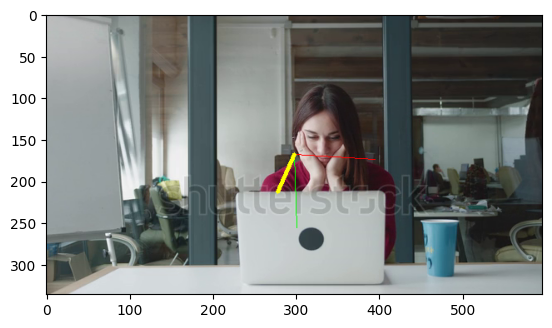

In [30]:
# 지정한 프레임에서의 추론 결과 시각화
import matplotlib.pyplot as plt

img = cv2.cvtColor(frame_list[100], cv2.COLOR_BGR2RGB)
print("yaw value:", yaw_values[100])
print("pitch value:", pitch_values[100])
plt.imshow(img)

yaw value: [42.708675]
pitch value: [-14.045211]


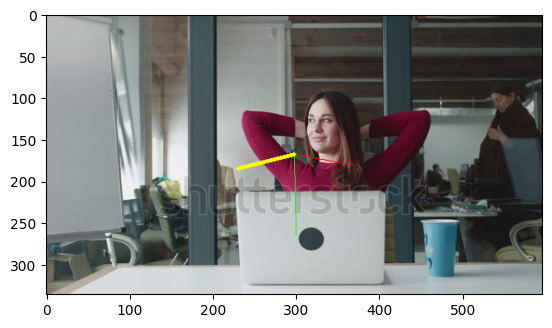

In [31]:
# 지정한 프레임에서의 추론 결과 시각화
import matplotlib.pyplot as plt

img = cv2.cvtColor(frame_list[250], cv2.COLOR_BGR2RGB)
print("yaw value:", yaw_values[250])
print("pitch value:", pitch_values[250])
plt.imshow(img)